In [7]:
from smac.model.gaussian_process.kernels import MaternKernel, ConstantKernel, RBFKernel
from smac.model.gaussian_process.gaussian_process import GaussianProcess
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace import ConfigurationSpace
from smac.intensifier.hyperband import Hyperband
# from train_gpt2_hpo import train_eval_hpo, setup_logger, print_with_tabs
from smac import MultiFidelityFacade, RunHistory, Scenario
from smac.runhistory.dataclasses import TrialValue
from functools import partial


In [8]:
def train_eval_hpo(
    config_space: ConfigurationSpace, 
    seed: int,
    budget: int,
    input_bin: str = "dev/data/fineweb10B/fineweb_train_*.bin",
    input_val_bin: str = "dev/data/fineweb10B/fineweb_val_*.bin",
    model: str = "d6",
    batch_size: int = 4,
    # sequence_length: int = 1024,
    total_batch_size: int = -1,
    # learning_rate: float = 1e-4,
    warmup_iters: int = 700, #0,
    learning_rate_decay_frac: float = 0.0,):
    
    learning_rate = config_space["learning_rate"]
    weight_decay = config_space["weight_decay"]
    sequence_length = config_space["sequence_length"]

    return learning_rate * weight_decay * sequence_length

partial_function = train_eval_hpo #partial(train_eval_hpo, batch_size=4) 

cs = ConfigurationSpace()
learning_rate = UniformFloatHyperparameter("learning_rate", 1e-6, 1e-3, default_value=1e-4, log=True)
weight_decay = UniformFloatHyperparameter("weight_decay", 1e-6, 0.1, default_value=0.01, log=True)
sequence_length = UniformIntegerHyperparameter("sequence_length", 256, 1024, default_value=1024)
cs.add_hyperparameters([learning_rate, weight_decay, sequence_length])


[learning_rate, Type: UniformFloat, Range: [1e-06, 0.001], Default: 0.0001, on log-scale,
 weight_decay, Type: UniformFloat, Range: [1e-06, 0.1], Default: 0.01, on log-scale,
 sequence_length, Type: UniformInteger, Range: [256, 1024], Default: 1024]

In [9]:
scenario = Scenario(
            cs,
            name="SMAC_trial_2",
            # objectives=["val_loss", "train_time"],
            walltime_limit=23*60*60, #60*60*23,  
            n_trials=500,  # Evaluate max 500 different trials
            min_budget=0.02*60*60,#0.75*60*60,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
            max_budget=0.16*60*60,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
            n_workers=1,
            seed=0,
            deterministic=True
        )
kernel = MaternKernel(nu=2.5) * ConstantKernel(1.0, constant_value_bounds="fixed")  # Radial Basis Function (RBF) kernel
model = GaussianProcess(configspace=cs, kernel=kernel)
initial_design = MultiFidelityFacade.get_initial_design(scenario, n_configs=5)
intensifier = Hyperband(scenario, eta=2)
smac = MultiFidelityFacade(
            scenario=scenario,
            target_function=partial_function,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=False,            
            model=model,
            # acquisition_function=acquisition_function,
        )

[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[WARNING][target_function_runner.py:74] The argument input_bin is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:74] The argument input_val_bin is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:74] The argument model is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:74] The argument batch_size is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:74] The argument total_batch_size is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:74] The argument warmup_iters is not set by SMAC: Consider removing it from the target function.
[WARNING][target_function_runner.py:74] The argument learning_rate_decay_frac is not set by SMAC: Consider r

In [10]:
for i in range(20):
    info = smac.ask()
    assert info.seed is not None
    print(info)
    cost = train_eval_hpo(info.config, budget=info.budget, seed=info.seed)
    value = TrialValue(cost=cost, time=0.5)

    smac.tell(info, value)

[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 2, min budget 72.0, and max budget 576.0.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [8, 4, 2, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [6, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [4, 2]
[INFO][successive_halving.py:325] --- Bracket 3: [4]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [72.0, 144.0, 288.0, 576.0]
[INFO][successive_halving.py:329] --- Bracket 1: [144.0, 288.0, 576.0]
[INFO][successive_halving.py:329] --- Bracket 2: [288.0, 576.0]
[INFO][successive_halving.py:329] --- Bracket 3: [576.0]
TrialInfo(config=Configuration(values={
  'learning_rate': 4.430375245218267e-05,
  'sequence_length': 752,
  'weight_decay': 0.009091283280651459,
}), instance=None, seed=20

# Wandb extract run info

In [1]:
import wandb
api = wandb.Api()
user = "o-swelam"
project = "LLMs"

# Initialize the API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{user}/{project}")

In [2]:
target_lr = 0.00016053955926854287
target_wd = 1.752934617105172e-05
target_sl = 995
matching_runs = []

# Loop through each run and filter by the config values
for run in runs:
    config = run.config  # Run's configuration dictionary
    # print(config)
    config_space = run.config.get("config_space")
    if config_space is None:
        continue
    # Check if 'lr', 'wd', and 'sl' are in the config and match the target values
    if ('learning_rate' in config_space and config_space['learning_rate'] == target_lr and
        'weight_decay' in config_space and config_space['weight_decay'] == target_wd and
        'sequence_length' in config_space and config_space['sequence_length'] == target_sl):
        matching_runs.append(run.history())


In [3]:
import pandas as pd

combined_df = pd.concat(matching_runs).sort_values("step").reset_index(drop=True)
deduplicated_df = combined_df.drop_duplicates(subset='step', keep='last')

# Sort again by step (optional, if you want it sorted after deduplication)
deduplicated_df = deduplicated_df.sort_values("step").reset_index(drop=True)
deduplicated_df

,remaining_time,lr,step,_step,_runtime,val_loss,_timestamp,avg train loss
0,1293.471640,2.293422e-07,0,0,15.561036,NaN,1.726958e+09,10.907496
1,1228.248840,4.609779e-05,200,1,80.783836,NaN,1.726958e+09,9.689851
2,1154.842500,9.196623e-05,400,2,154.235890,NaN,1.726958e+09,7.593662
3,1081.270941,1.378347e-04,600,3,227.803928,NaN,1.726958e+09,6.976192
4,1007.411828,1.605396e-04,800,4,301.620855,NaN,1.726958e+09,6.713572
...,...,...,...,...,...,...,...,...
2046,22520.815168,1.240630e-04,408000,1254,60285.614396,NaN,1.727773e+09,4.388056
2047,22470.708114,1.240302e-04,408200,1255,60335.721387,NaN,1.727773e+09,4.398064
2048,22420.646646,1.239974e-04,408400,1256,60385.782899,NaN,1.727773e+09,4.389914
2049,22370.617292,1.239645e-04,408600,1257,60435.812266,NaN,1.727773e+09,4.397418


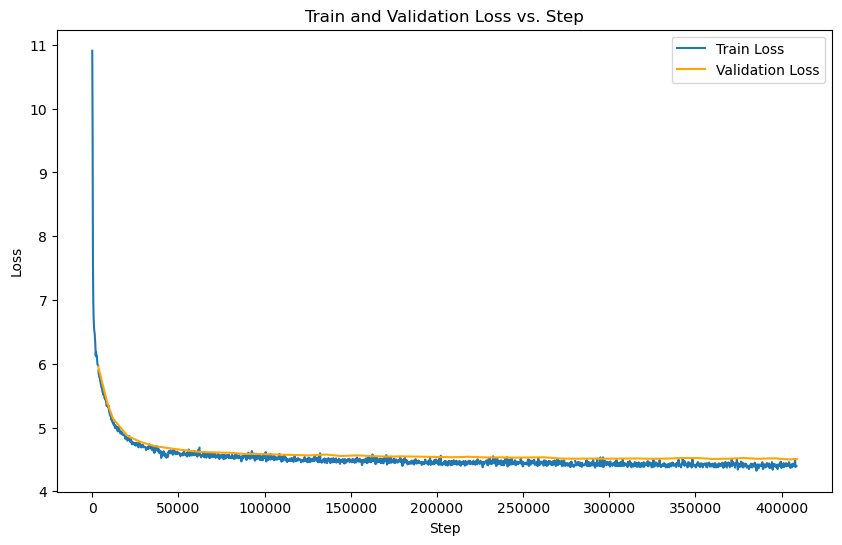

In [6]:
import matplotlib.pyplot as plt

# Plotting train and validation losses on the same plot
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(deduplicated_df['step'], deduplicated_df['avg train loss'], label='Train Loss')

# Plot validation loss, filtering out the zero or negative values
plt.plot(deduplicated_df[deduplicated_df['val_loss'] > 0]['step'], 
         deduplicated_df[deduplicated_df['val_loss'] > 0]['val_loss'], 
         label='Validation Loss', color='orange')

# Add labels and title
plt.title('Train and Validation Loss vs. Step')
plt.xlabel('Step')
plt.ylabel('Loss')

# Show legend
plt.legend()

# Display the plot
plt.show()
